# 因子投资中的机器学习—— Chapter 3 数据预处理

**作者**: 林劲展  
**日期**: 2024-09-20  
**电子邮件**: jinzl@stu.pku.edu.cn  
**电话号码**: +86 13026888733  
**单位**: 北京大学汇丰商学院  
**专业方向**: 数量金融

---

## 项目简介
<p><span style="font-size: 18px;">
这一部分主要是数据预处理的具体步骤。针对不同模型和不同预测目标，选择数据形式是必要的。共同点是，无论做什么样的预测，保证数据质量都是重中之重。

### 一、认识你的数据
<p><span style="font-size: 18px;">
1、选择你所需要的数据类型，选择可靠的数据供应商。
<p><span style="font-size: 18px;">
2、查看摘要统计量，如取值范围、均值和中位数。除了一阶矩，二阶矩如方差、协方差和相关性也很重要。若两个公司的特征高度相同，在一些模型会出现问题。
<p><span style="font-size: 18px;">
通常下，由于预测变量太多，为简化分析，最低限度的验证是：（1）关注预测变量的子集。例如，与常见的因子（市值、市盈率或市净率、动量、盈利能力、净资产增长率、波动率）相关的预测变量。（2）追踪摘要统计量的异常值。最大值和中位数之比或中位数和最小值之比。

<p><span style="font-size: 18px;">以下展示了公司特征与未来一个月收益率的相关系数分布。相关系数是在整个股票截面上计算出来的，大多位于0附近，但在有些日期发生了极端变量，其中黑点显示了离群值。市值和未来收益率相关系数中位数是负值中最小的，而波动率是唯一一个和收益率相关系数的中位数大于0的量。

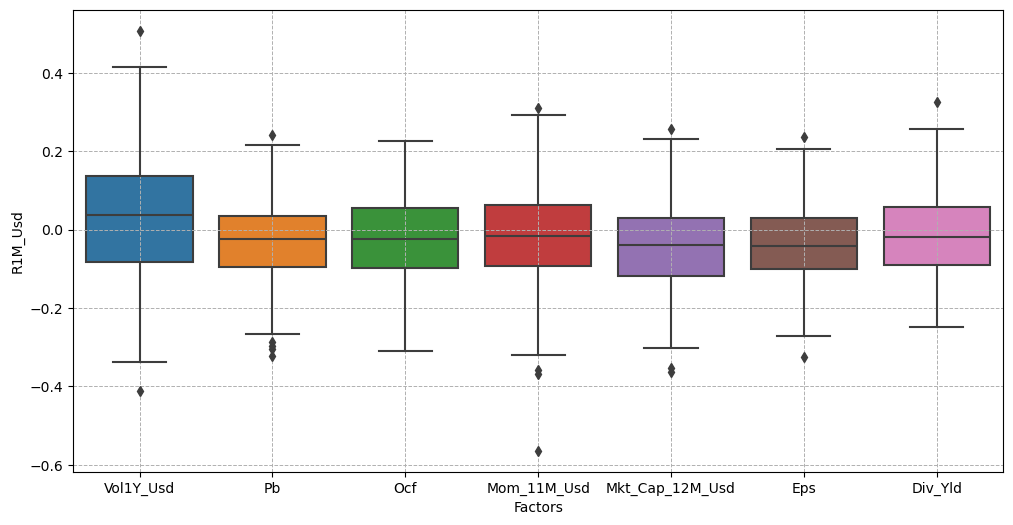

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data_ml = pd.read_csv('data_ml.csv')

# Specify the features and label
features_short = ['Vol1Y_Usd','Pb','Ocf','Mom_11M_Usd','Mkt_Cap_12M_Usd','Eps','Div_Yld']
cols = features_short + ['R1M_Usd', 'date']

# Create the working dataset
data_corr = data_ml[cols]

# Group by date and compute correlation
data_corr = data_corr.groupby('date').corr()[['R1M_Usd']].reset_index()

# Remove rows where the correlation is 1 (i.e., with itself)
data_corr = data_corr.loc[data_corr[data_corr.level_1.str[-7:] != "R1M_Usd"].index]

# Rename the level_1 column to "Factors"
data_corr.rename(columns={'level_1': "Factors"}, inplace=True)

# Plot a boxplot for the correlation coefficients
plt.figure(figsize=(12,6))
sns.boxplot(x="Factors", y="R1M_Usd", data=data_corr)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
# Display the plot
plt.show()


<p><span style="font-size: 18px;">在进行监督学习时，特征与因变量的联系可以用平滑的条件均值进一步描述。如下：

<p><span style="font-size: 18px;">$$Y=f(x)+error$$
<p><span style="font-size: 18px;">$$f(x)=E[Y|X=x]$$$where f $是最小化均方差 $E[(Y-f(X))^2]$的回归函数。

<p><span style="font-size: 18px;">在下图，设定因变量是未来一个月的收益，可视化两个不同特征与目标变量之间的关系。第一个预测变量是过去一年的市值平均值，另一个则是过去一年的波动率。曲线周围阴影部分表示平均值95%置信区间。

C:\Users\36119\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\36119\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


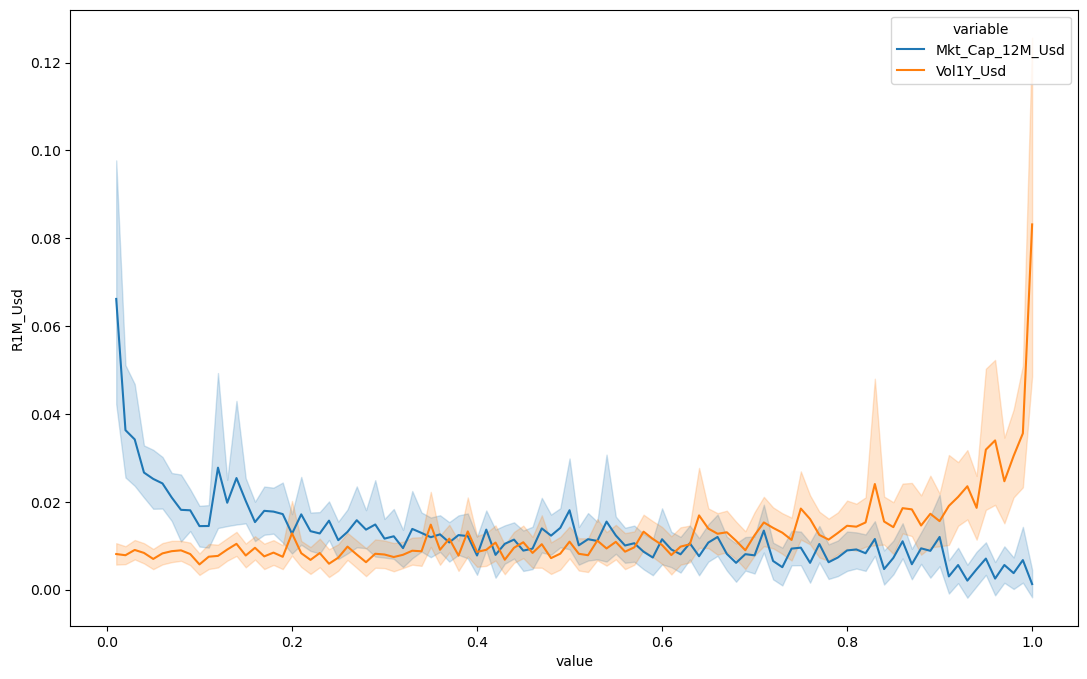

In [8]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
plt.figure(figsize=(13,8))
sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

<p><span style="font-size: 18px;">可见，这两个变量对未来收益有近乎单调的影响。平均来说，收益率随着市值的增加而减少，反而证实了规模效应——根据该理论，小市值公司由于具有更高的成长潜力、风险较高，因此预期回报率（或者说收益率）相对较高。而大市值公司规模大、经营稳定，因此其风险和增长潜力较低，导致回报率较低。

<p><span style="font-size: 18px;">对于波动率来讲，单调递增性在前半部分不那么明显，在波动率值后的最后一段快速攀升，与低波动率异象矛盾。（低波动率异象的核心观点是，波动率低的股票实际上提供了比高波动率股票更好的风险调整后回报率。这种现象与传统的风险-回报理论相悖。）

<p><span style="font-size: 18px;">似乎传统的风险-回报理论依然适用。

<p><span style="font-size: 18px;">公司特征的一个重要经验属性是自相关。如果一个预测变量的自相关程度很高时，在一些数据点缺失的情况下，简单的插补技术是合理的。预测任务时，自相关也很重要。以下代码对每一只股票的每一个特征计算了自相关系数，并绘制了相应的直方图，可能比较费时。

C:\Users\36119\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


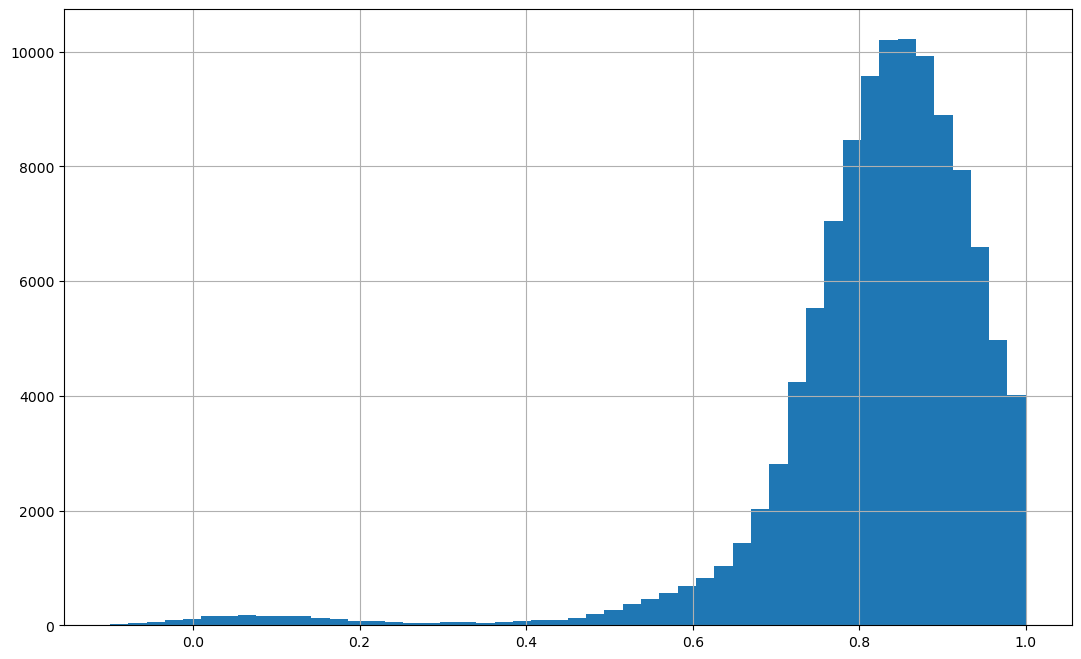

In [10]:
cols=[]                                 # cleaning the column list from previous use
cols = ['stock_id'] + list(data_ml.iloc[:,3:95].columns) # Keep all features and stockid
# below the nested line of code for sorting according the pair stockid/variable and then compute the acf
data_hist_acf=pd.melt(data_ml[cols], id_vars='stock_id').groupby(['stock_id','variable']).apply(lambda x: x['value'].autocorr(lag=1))
plt.figure(figsize=(13,8))
data_hist_acf.hist(bins=50,range=[-0.1,1]); # Plot from pandas

<p><span style="font-size: 18px;">可见绝大多数的预测变量都是高度自相关的。

### 二、缺失值
<p><span style="font-size: 18px;">
主要有两种处理缺失值的方法：移除法和插补法。移除法后果不清晰且代价很高，特别是在观察值只缺失了一个特征时；插补法通常是首选，但会依赖于一些潜在、可能出错的假设。
<p><span style="font-size: 18px;">
插补法有几种简单方式如下：


基本的插补选择是股票特征相对于过去可用值的中位数（或平均值）。如果时间序列中存在趋势，这仍然会改变趋势。与此相关的是，这种方法可能用到了未来信息，除非将训练集和测试集分开处理。


在时间序列中，考虑到回撤，最简单的插补来自历史数据。但是，在某些特定情况下，这可能是一个非常糟糕的选择（请参阅下面的警告）。


资产横截面的中位数和均值可以作为插补，即重新定位到观测值分布最集中的部分。当缺少许多值时，这会产生新数据改变原始分布。一个优点是这不会用到未来数据。


许多技术依赖于数据生成过程的一些建模假设。我们指的是非参数方法（Stekhoven 和 Bühlmann （2011） 以及 Shah et al. （2014），它们依赖于随机森林，见第 6 章）、贝叶斯插补 （Schafer （1999））、最大似然法 （Enders （2001）、Enders （2010））、插值或外推以及最近邻算法 （Garcı́a-Laencina et al. （2009））。更一般地说，小节开头引用的四本书详细介绍了许多这样的插补过程。高级技术在计算上要求要高得多。


注意：


对于每个季度发布的会计值或比率绝不能进行线性插值，无论如何都不能使用插值法。原因很简单，因为这会用到未来信息。如果数字在 1 月和 4 月披露，那么插入 2 月和 3 月需要知道 4 月的数字，这在实时交易中是未知的。采用历史数据是更好的方法。


尽管如此，仍应避免对某些特征类型采用历史数据的插补。首先，收益率不应该被简单复制。默认情况下，更好的选择是将缺失的收益率设置为零（通常接近平均值或中位数）。有助于决策的一个很好的指标是该功能随时间的持续性。如果它是高度自相关的（并且时间序列图会创建一条平滑的曲线，就像市值一样），那么过去的插补是有意义的。如果没有，那么应该避免。
有些情况可能需要更多关注。让我们考虑以下虚构的股息收益率样本：


以股息率为例，有三种选择，分别是保持前值，对前值的递推以保持趋势，设为0。


当然也有一些处理数据插补的软件包。

### 三、异常值检测

<p><span style="font-size: 18px;">有些复杂的异常值检测方法比较费力，而且收益有限。简单的启发式处理方法往往就足够了，但可能所需的使用条件比较苛刻，如下：

给定一个特征，均值上下m个标准差以外的任何值都可被认为是异常值，m通常取3、5、10；

如果最大值高于次大值m倍，也可被归类于异常值；

给定很小的阈值q，位于分位数区间[q,1-q]以外的值都可被认定为异常值。

最后这种方法被称为缩尾化。即缩尾化的变量$\tilde{x}_i$如下：

$$
\tilde{x}_i = 
\begin{cases} 
x_i & \text{if } x^{(q)}<x_i<x^{(1-q)} \\
x^{(q)} & \text{if } x_i<x^{(q)} \\
x^{(1-q)} & \text{if } x_i>x^{(1-q)} \\
\end{cases}
$$


<p><span style="font-size: 18px;">q通常在区间（0.5%，5%）取值，1%和2%最常用。缩尾化必须逐个特征逐个日期进行。然而保持一个时间序列的整体视角也是必要的，对于一些有突出特征的公司。真正的异常值，即不是数据错误，很可能携带重要信息。

### 四、特征工程
<p><span style="font-size: 18px;">
1、特征选择
<p><span style="font-size: 18px;">
特征工程第一步是特征选择。比较普遍的特征选择方法是选择文献中经常提到的变量。当然这样难以获得超额收益，因为所有交易者都会考虑到这些特征。特征选择可以源于经验研究或论文模型，或将基本面价值作为独立变量纳入预测模型。
<p><span style="font-size: 18px;">
第二步是给定足够大的预测变量集，过滤掉冗余变量。可用的一些方法如下：

计算所有特征的相关系数矩阵，确保没有一个值的绝对值超过阈值，阈值通常为0.7；


进行线性回归并删除不显著的变量，如p值超过0.05；


对特征集进行聚类分析，每个聚类只保留一个特征；

使用决策树模型，保留重要性较高的特征。

<p><span style="font-size: 18px;">
2、缩放预测变量

<p><span style="font-size: 18px;">金融数据中存在大量数量级不同的数据。虽然人们普遍认为特征的单调变换对预测结果的影响很小，但有些研究表明情况并非一成不变。因此，标准化的选择可能非常重要，常见的缩放法如下：

标准化：$\tilde{x}_i=\frac{x_i-m_x}{\sigma_x},m_x和\sigma_x分别是均值和标准差$

线性函数归一化：$\tilde{x}_i=\frac{x_i-min(x)}{max(x)-min(x)}$

[-1,1]线性函数归一化：$\tilde{x}_i=2\frac{x_i-min(x)}{max(x)-min(x)}-1$

均匀化：$\tilde{x}_i=F_x(x_i),F_x是x的经验累积概率分布函数，\tilde{x}被认为在[0,1]服从均匀分布$

有时可以对既有大数又有大离群值的变量如市值进行对数变换，之后再进行缩放。

<p><span style="font-size: 18px;">在对神经网络进行训练前，对训练数据进行线性函数归一化缩放往往是必要的。我们的数据集是经过均匀化处理的：对于每个时间点，每个特征的横截面分布在单位时间内是均匀的。在因子投资中，必须对于每个日期和每个特征分别进行特征缩放，以确保每个再平衡的日期，预测变量将有类似分布，并携带股票横截面的信息。均匀化有时以不同方式实施，如下：

对于给定特征和时间点，对原始特征取值进行排序，然后将排序除以非缺失值的数量。

同时应该禁止跨日期缩放特征。例如市值从长远来看是递增的。跨日期的缩放会导致市值初期过小，后期又过大。

### 五、打标签
<p><span style="font-size: 18px;">
1、简单的打标签方法
<p><span style="font-size: 18px;">最常见的标签有以下几种：

资产的原始收益率；

未来的相对收益率，相对基准为全市场指数，即将收益减去横截面数据的均值或中位数；

正收益概率或收益高于特定阈值概率；

给定时间范围内超越基准的概率；

上述的二元版本，即二分类；

上述的风险调整版本，如夏普比率、信息比率、MAR、CALMAR等等

<p><span style="font-size: 18px;">创建二分类时，基准设置为固定值往往会导致不同市场情形下，极不平衡的数据，更好的方法是与中位数或均值比较。

<p><span style="font-size: 18px;">2、类别标签

<p><span style="font-size: 18px;">当预测目标被当作名义分类变量时，也即作为离散投资决策时，类别就必须重新编码为数字，因为机器学习只能处理实际数字。最常见的映射被称为独热编码。类别向量被分割为稀疏矩阵，每一列都专门用于一个类别，矩阵由0和1构成。独热编码通过为每个类别创建一个独立的二进制列，保留了所有类别的详细信息，每个类别都被明确地表示。对于分类问题，这样可以清晰地区分不同类别，而不会丢失任何细节。不会引入人为的顺序或等级关系，适合无序的类别数据。例如，使用独热编码对操作（买入、持有、卖出）进行编码时，类别之间没有隐含的数值大小或顺序。特别适合用于需要明确区分类别的非线性模型，如决策树、随机森林等。

| Initial data | One-hot  | encoding |  |
|--------------|------------------|----|----|
| Position     | Sell             | Buy| Buy|
| buy          | 0                | 0  | 1  |
| buy          | 0                | 0  | 1  |
| hold         | 0                | 1  | 0  |
| sell         | 1                | 0  | 0  |
| buy          | 0                | 0  | 1  |


<p><span style="font-size: 18px;">3、三栅栏法

<p><span style="font-size: 18px;">三栅栏法是一种高阶的打标签方法，考虑了交易策略的动态表现，而不是一个简单的业绩指标。符合止盈、止损的实际交易操作。设定了三个栅栏，分别是高于当前价格的预期值，衡量合理的预期利润；低于当前价格的预期值，作为止损信号，防止大量亏损；固定持有期限，超过期限即终止交易。

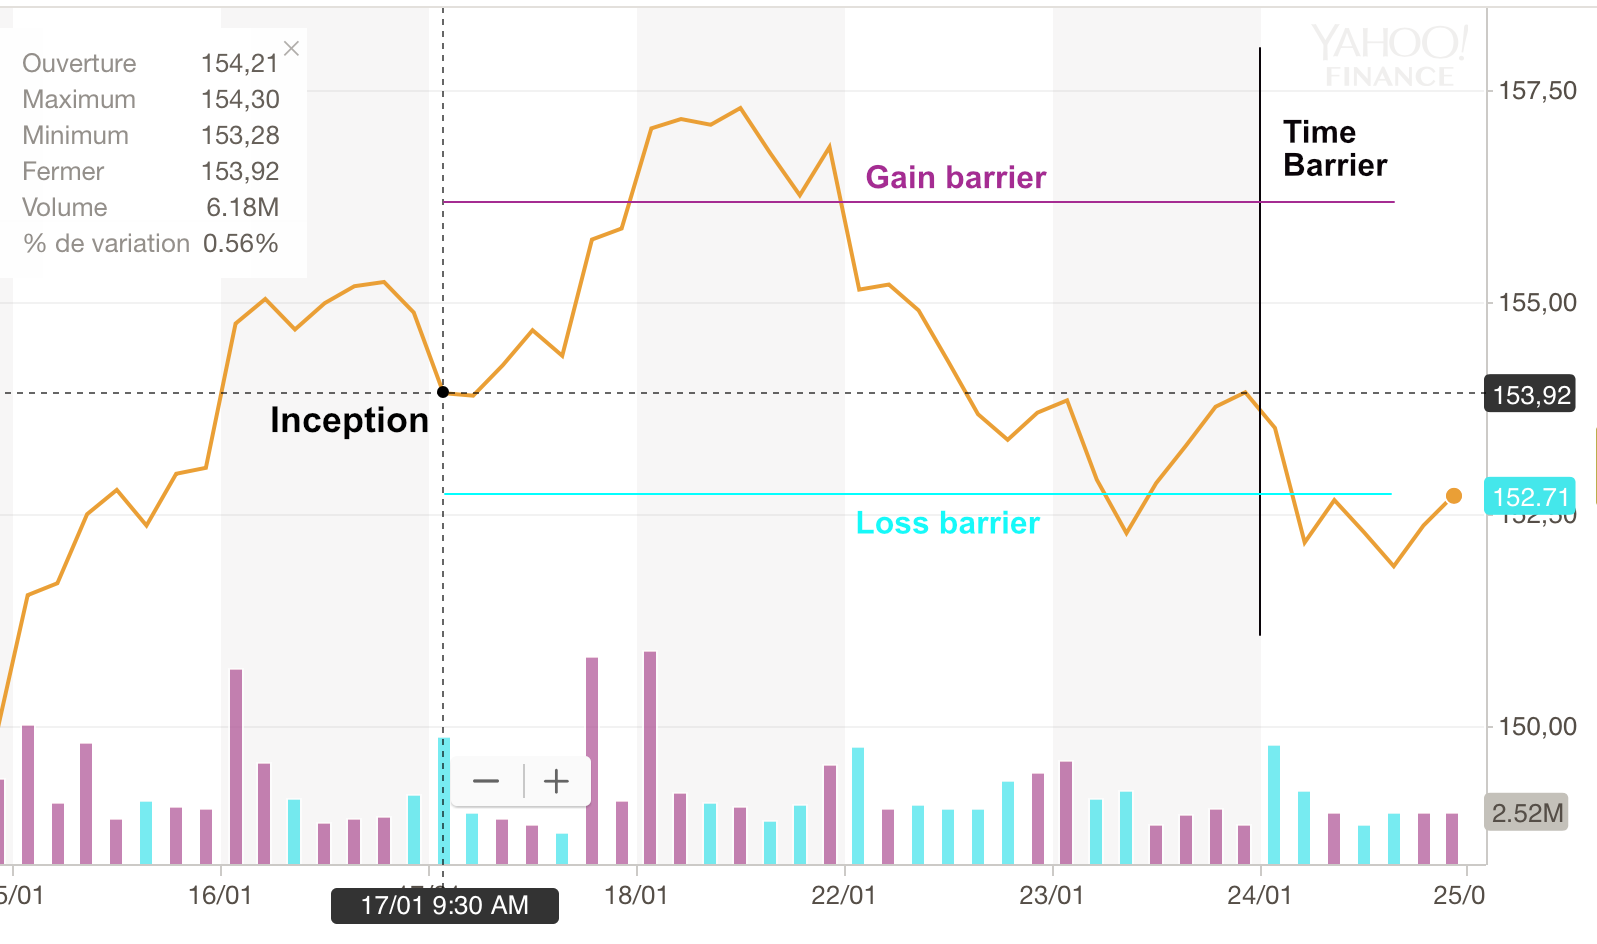

<p><span style="font-size: 18px;">4、过滤样本

<p><span style="font-size: 18px;">收集的样本数据越多并不意味着可以提取的信号就越多，更多的数据也意味着更多的噪声。因而对于训练样本的过滤可以提高机器学习模型的性能。
Coqueret 和 Guida (2020) 研究了为何较小的样本可能会提高某些机器学习算法（如决策树）的样本外预测精度。作者使用了一种特殊的过滤方法，即排除中间的标签值（如回报率），仅保留最小的20%和最大的20%数据。这种方法改变了决策树的结构，具体表现为：分割点更接近分割变量的中心，使得结果更平衡、更稳健；分割变量的选择更倾向于那些对标签有单调影响的特征。这些特性是有利的，第一点减少了过拟合小数据组的风险，第二点则让更相关的特征在解释回报率时占据更重要的位置。然而，过滤不能过于严格，若只保留10%的尾部数据，信号损失过多，性能会下降。

<p><span style="font-size: 18px;">5、收益率的时间尺度

<p><span style="font-size: 18px;">非常远古的研究表明，最成功的零成本多空策略时根据过去一年的收益率选择股票，然后持有一个季度。但结论是时间尺度很重要。震荡或平滑的标签和震荡或平滑的特征可能组成不同的组合。平滑的特征和平滑的标签可能更稳健。由于特征往往是高度自相关的，将他们与平滑标签结合起来可能更好。模型才能提取一些可以从缓慢移动的序列之间提取稳定模式。

### 六、处理持续性问题

<p><span style="font-size: 18px;">标签和特征之间的自相关模式不应该相差过大。如数据集以月度频率取样时，标签是月度收益率，而特征是风险或基本面指标。在这种情况下，标签自相关性弱，而特征往往是高度自相关的。复杂的预测模型则会在特征之间进行套利，这可能会导致大量噪声，导致估计偏差。

<p><span style="font-size: 18px;">解决方案：(1)、在更长的时间尺度上计算收益，以增加标签的自相关。(2)、使用差分或变分，以移除特征自相关性。

### 七、扩展

<p><span style="font-size: 18px;">1、特征变换：考虑时滞法取特征旧值；引入特征之间的比率或乘积，但要在经济学上有意义；考虑差分，有时候变化比水平更重要。

<p><span style="font-size: 18px;">2、宏观经济指标：一个特定模型的性能很可能取决于总体经济情况。数据上，可能简单将特征乘以一个外部指标；或有条件的特征工程。

<p><span style="font-size: 18px;">
$$r_{t,±}=r_±×e^{±δ(VIX_t-\bar{VIX})}$$

<p><span style="font-size: 18px;">即在市场恐慌动荡时，同时增加买入或卖出阈值，参数δ作为调整幅度。

<p><span style="font-size: 18px;">3、主动学习：专注于包含最大信息量的观测值的技术成为主动学习。在因子投资中，主动学习的适用性取决于数据是否能够由人工标注。主动学习的一个关键点是模型可以模拟数据实例并请求相应的标签，但是在因子投资中，数据通常不适合通过人为干预来标注。因此，模型可能无法像典型主动学习那样自动选择实例并获取标签。

### 八、缩放的影响

<p><span style="font-size: 18px;">生成一个任意序列，进行缩放。

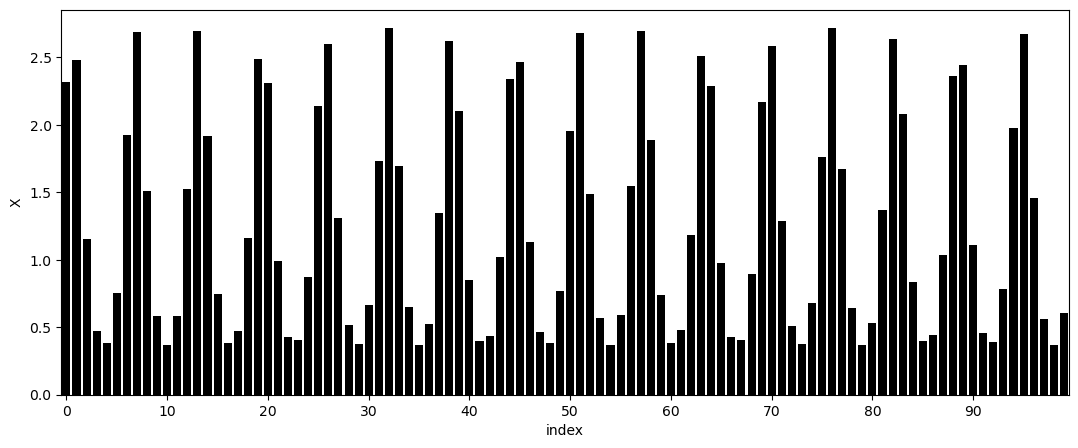

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

length = 100
x = np.exp(np.sin(np.linspace(1,length,length)))
data = pd.DataFrame(data=x,columns=['X'])
data.reset_index(inplace=True)
plt.figure(figsize=(13,5)) # resizing figure
sns.barplot(y="X", data=data, x="index", color='black'); # Plot from Seaborn
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

<p><span style="font-size: 18px;">绘制被缩放的序列。

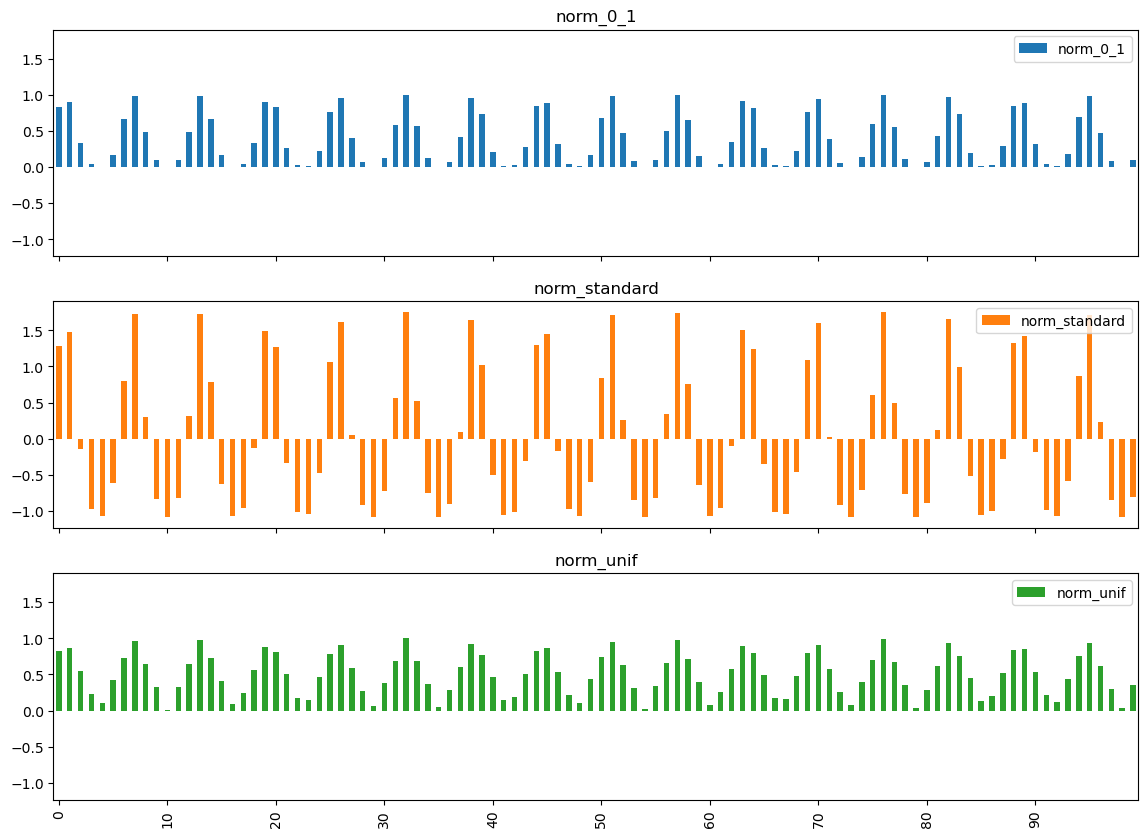

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF # to use the ECDF built in function
def norm_0_1(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
def norm_unif(x):
    return (ECDF(x)(x))
def norm_standard(x):
    return (x- np.mean(x))/np.std(x)

data_norm=pd.DataFrame.from_dict(dict( # ensembling numpy arrays into a dict and then a pd dataframe
index=np.linspace(1,length,length), # creating the index
norm_0_1=norm_0_1(x), # normalisation [0,1]
norm_standard=norm_standard(x), # standardisation
norm_unif=norm_unif(x))) # Uniformisation
data_norm.iloc[:,1:4].plot.bar( figsize=(14,10), subplots=True, sharey=True, sharex=True); # Plot
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

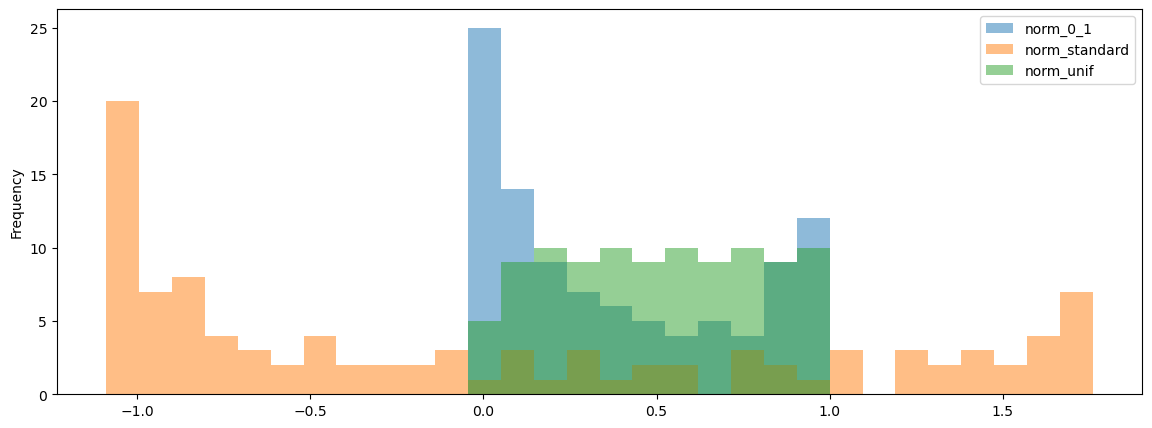

In [7]:
data_norm.iloc[:,1:4].plot.hist(alpha=0.5, bins=30, figsize=(14,5)); # Plot from pandas, alphas=opacity

<p><span style="font-size: 18px;">可见绿色和橙色的分布接近于原始分布，只是数字发生了变化。min-max缩放确保了所有值都处于0到1范围。但是左侧尖峰在均匀化消失了。

<p><span style="font-size: 18px;">以下是一个简单的数据集，包含三家公司的各三个时间点。

In [8]:
import statsmodels.api as sm
from IPython.display import display, Markdown
cap=np.array([10,50,100, # Market capitalization
              15,10,15,
              200,120,80])
returns=np.array([0.06,0.01,-0.06, # Return values
        -0.03,0.00,0.02,
        -0.04,-0.02,0.00])
date=np.array([1,2,3,1,2,3,1,2,3]) # Dates
firm=np.array([1,1,1,2,2,2,3,3,3]) # Firms (3 lines for each)
toy_data=pd.DataFrame.from_dict(dict(firm=firm,date=date,cap=cap,returns=returns, # Aggregation of data
cap_norm=norm_0_1(cap),
cap_u=norm_unif(cap))) 
display(Markdown(toy_data.to_markdown())) # Introducing Markdown and printing the table

|    |   firm |   date |   cap |   returns |   cap_norm |    cap_u |
|---:|-------:|-------:|------:|----------:|-----------:|---------:|
|  0 |      1 |      1 |    10 |      0.06 |  0         | 0.222222 |
|  1 |      1 |      2 |    50 |      0.01 |  0.210526  | 0.555556 |
|  2 |      1 |      3 |   100 |     -0.06 |  0.473684  | 0.777778 |
|  3 |      2 |      1 |    15 |     -0.03 |  0.0263158 | 0.444444 |
|  4 |      2 |      2 |    10 |      0    |  0         | 0.222222 |
|  5 |      2 |      3 |    15 |      0.02 |  0.0263158 | 0.444444 |
|  6 |      3 |      1 |   200 |     -0.04 |  1         | 1        |
|  7 |      3 |      2 |   120 |     -0.02 |  0.578947  | 0.888889 |
|  8 |      3 |      3 |    80 |      0    |  0.368421  | 0.666667 |

<p><span style="font-size: 18px;">似乎投资小市值的公司是一个好策略。经过以下的简单回归，从p值看，可见minmax缩放的效果不如标准化变量，使用标准化变量可以减小差异性或离散性。

In [9]:
X=toy_data.cap_norm.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     4.265
Date:                Mon, 30 Sep 2024   Prob (F-statistic):             0.0778
Time:                        14:56:29   Log-Likelihood:                 19.892
No. Observations:                   9   AIC:                            -35.78
Df Residuals:                       7   BIC:                            -35.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0124      0.014      0.912      0.3

C:\Users\36119\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [10]:
X=toy_data.cap_u.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     6.672
Date:                Mon, 30 Sep 2024   Prob (F-statistic):             0.0363
Time:                        14:56:42   Log-Likelihood:                 20.764
No. Observations:                   9   AIC:                            -37.53
Df Residuals:                       7   BIC:                            -37.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0457      0.022      2.056      0.0

C:\Users\36119\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
